# Imports and constants

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, ADAM
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

from sklearn.datasets import fetch_openml

import torch

import torchvision.models as models

In [2]:
BACKEND = "qasm_simulator"

num_inputs = 2 # num of features (n)
num_samples = 64 # num of samples
num_params = 12 # num of parameters (m)
num_qubits = 2 # num of qubits

# Dataset

In [3]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Extract data and target
X_mnist, y_mnist = mnist["data"], mnist["target"]

# Print statistics
print(f"Number of samples: {X_mnist.shape[0]}")
print(f"Number of features: {X_mnist.shape[1]}")
print(f"Number of classes: {len(set(y_mnist))}")
print(f"Classes: {set(y_mnist)}")

Number of samples: 70000
Number of features: 784
Number of classes: 10
Classes: {'3', '5', '2', '1', '9', '6', '4', '8', '0', '7'}


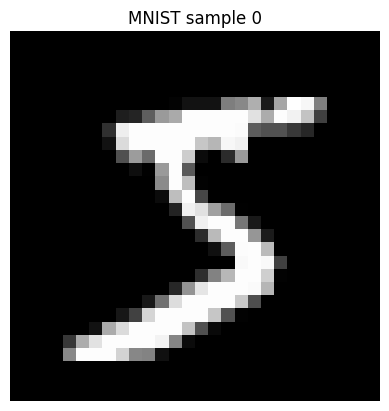

Label: 5


In [4]:
def plot_sample(i):
    # Reshape the i-th sample to a 28x28 image
    image = X_mnist.iloc[i].values.reshape(28, 28)

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"MNIST sample {i}")
    plt.axis('off')
    plt.show()

plot_sample(0)

print(f"Label: {y_mnist[0]}")

# Preprocess

In [5]:
# Load a pretrained ResNet model, trained on ImageNet so not MNIST
resnetBackbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the last layer (fully connected layer)
resnetBackbone = torch.nn.Sequential(*(list(resnetBackbone.children())[:-1])) 

input = torch.randn(1, 3, 224, 224)
output = resnetBackbone(input)
print(output.shape)

# resnetbackbone :
#input shape : 1, 3, 224, 224
#output shape : 1, 512, 1, 1

torch.Size([1, 512, 1, 1])


In [6]:
print(type(X_mnist.values))
print(X_mnist.values[:5].shape)

for fqsdv in X_mnist.values[:5]:
    print(fqsdv.shape)

<class 'numpy.ndarray'>
(5, 784)
(784,)
(784,)
(784,)
(784,)
(784,)


In [7]:

img0 = X_mnist.values[0]

print(img0.shape)
img0_tensor = torch.tensor(img0 / 255)
print(type(img0_tensor.detach().numpy()))
print(img0_tensor.detach().numpy().max())

(784,)
<class 'numpy.ndarray'>
1.0


In [8]:
# now we create the input we will use : one image = (512, 1, 1)

def processImage(image):
    """
    input shape : 784
    output shape : 1, 3, 224, 224
    """
    normalized_tensor = torch.tensor(image / 255.0, dtype=torch.float32)
    square_normalized_tensor = normalized_tensor.reshape(1, 1, 28, 28)
    reshaped_normalized_tensor = torch.nn.functional.interpolate(square_normalized_tensor, size=(224, 224), mode="bilinear")
    reshaped_normalized_tensor = reshaped_normalized_tensor.repeat(1, 3, 1, 1)

    return reshaped_normalized_tensor

#a = processImage(X_mnist.values[0])
#plt.imshow(a[0].permute(1, 2, 0).detach().numpy())

In [9]:
X = torch.stack([resnetBackbone(processImage(image)) for image in X_mnist.values[:num_samples]])

In [11]:

print(X.shape)

torch.Size([64, 1, 512, 1, 1])


# Circuit

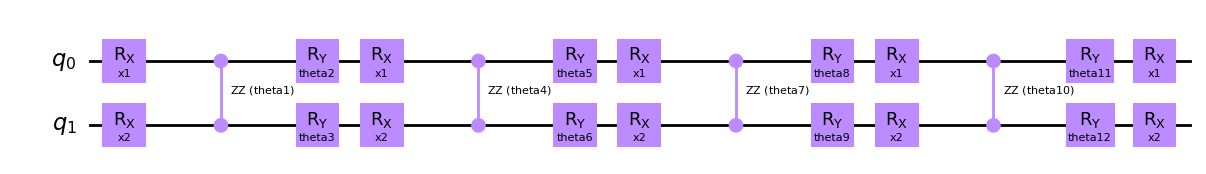

In [17]:
# 14 parameters : x1, x2, theta1, ...theta12
params = [Parameter(f"x{i}") for i in range(1, num_inputs+1)] + [Parameter(f"theta{i}") for i in range(1, num_params+1)]

qcc = QuantumCircuit(num_qubits) 

x1 = params[0]
x2 = params[1]
theta1 = params[2]
theta2 = params[3]
theta3 = params[4]
theta4 = params[5]
theta5 = params[6]
theta6 = params[7]
theta7 = params[8]
theta8 = params[9]
theta9 = params[10]
theta10 = params[11]
theta11 = params[12]
theta12 = params[13]

qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta1, 0, 1)
qcc.ry(theta2, 0)
qcc.ry(theta3, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta4, 0, 1)
qcc.ry(theta5, 0)
qcc.ry(theta6, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta7, 0, 1)
qcc.ry(theta8, 0)
qcc.ry(theta9, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta10, 0, 1)
qcc.ry(theta11, 0)
qcc.ry(theta12, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)


qcc.draw("mpl", style="clifford")

In [15]:
# The classical part : 
# input shape = [batchSize, 512, 1, 1] (output of resnetBackbone)
# output shape = [batchSize, 2] (which will be given to qcc as x1 and x2)

class classicalPart(torch.nn.Module):
    def __init__(self):
        super(classicalPart, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(512, 2)
    
    def forward(self, x):
        #print('a', x.shape)
        x = self.flatten(x) # [batchSize, 512, 1, 1] -> [batchSize, 512]
        #print('b', x.shape)
        x = self.fc1(x) # [batchSize, 512] -> [batchSize, 2]
        #print('c', x.shape)
        return

In [27]:
class hybridModel(torch.nn.Module):
    def __init__(self, quantumCircuit, classicalPart):
        super(hybridModel, self).__init__()
        self.quantumCircuit = quantumCircuit
        self.classicalPart = classicalPart
        self.estimator = Estimator()
        self.qnn_estimator = EstimatorQNN(circuit=self.quantumCircuit,
                                          estimator=self.estimator,
                                            input_params=params[:2],
                                            weight_params=params[2:])
    
    def forward(self, x):
        x = self.classicalPart(x)
        x = self.quantumCircuit.forward(x)

        return x

In [28]:
cp = classicalPart()

hybridmodel = hybridModel(qcc, cp)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [29]:
res = hybridmodel(X[0])

print(res.shape)

AttributeError: 'QuantumCircuit' object has no attribute 'forward'

In [7]:
# On prépare notre Estimator
estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qcc, 
    estimator=estimator,
    input_params=[params[0]], 
    weight_params=[params[1], params[2], params[3], params[4]],
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [8]:
# On définit une callback function pour monitorer l'entrainement
def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# On prépare le classifier avec le circuit à entrainer et l'optimizer
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, 
    optimizer=COBYLA(maxiter=6), 
    callback=callback_graph
)

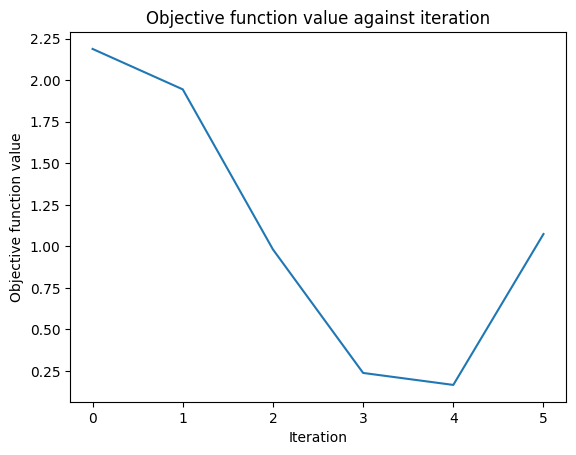

1.0

In [10]:
# On crée un array vide to stocker les valeurs de la loss pendant l'entrainement
objective_func_vals = []
# On fit le modèle aux données
estimator_classifier.fit(X, y)
# On affiche l'accuracy
estimator_classifier.score(X, y)

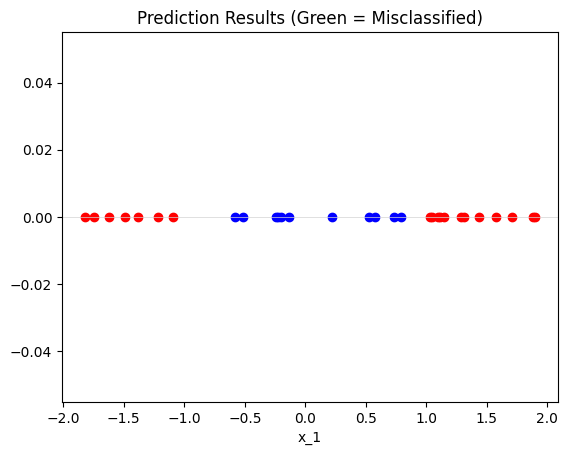

In [11]:
# On génère les valeurs prédites
y_predict = estimator_classifier.predict(X)

# On plot le résultat
# Red circles indicate misclassified points
for x, y_target, y_p in zip(X, y, y_predict):
    if y_p == 1:
        plt.plot(x[0], 0, "bo") 
    else:
        plt.plot(x[0], 0, "ro")
    
    # On entoure les instances mal classifiées en vert
    if y_target != y_p:
        plt.scatter(x[0], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Prediction Results (Green = Misclassified)")
plt.xlabel("x_1")
plt.show()

In [12]:
# On affiche les valeurs des theta_i
estimator_classifier.weights

array([1.74476216, 1.96750973, 1.32582536, 1.37045971])